In [1]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf
import time
import scipy

def vtlp_filters(fbank_mx, alpha=1.0, f_high=None):
    """
    Apply vocal tract length perturbation (VTLP) to the filterbank matrix.
    :param fbank_mx: filterbank matrix
    :param alpha: warping factor
    :param f_high: maximum frequency for warping
    :return: warped filterbank matrix
    """
    n_filters, n_fft = fbank_mx.shape
    warped_filters = np.zeros((n_filters, n_fft))
    
    if f_high is None:
        f_high = n_fft / 2
    
    for m in range(n_filters):
        for k in range(n_fft):
            f = (n_fft - 1) * k / (n_fft - 1)
            if f < f_high / 2:
                f_warped = alpha * f
            elif f < f_high:
                f_warped = alpha * f + (1 - alpha) * (f_high / 2)
            else:
                f_warped = f
            
            k_warped = int(n_fft * f_warped / (n_fft - 1))
            if k_warped < n_fft:
                warped_filters[m, k_warped] += fbank_mx[m, k]
    
    return warped_filters



def vtlp(input_wav_file, output_wav_file, alpha=1.0, f_high=None):
    """
    Apply vocal tract length perturbation (VTLP) to a .wav file.
    :param input_wav_file: input .wav file
    :param output_wav_file: output .wav file
    :param alpha: warping factor
    :param f_high: maximum frequency for warping
    """
    # Load the input .wav file
    y, sr = librosa.load(input_wav_file)
    
    # Compute the spectrogram
    n_fft = 2048
    hop_length = 512
    win_length = n_fft
    window = scipy.signal.windows.hann(win_length, sym=False)
    
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    
    # Compute the filterbank matrix
    n_mels = 256
    fbank_mx = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    
    
    # Apply VTLP to the filterbank matrix
    warped_filters = vtlp_filters(fbank_mx, alpha=alpha, f_high=f_high)
    
     
    # Compute the mel spectrogram using the warped filterbank matrix
    S = np.dot(warped_filters, np.abs(D))
    
       
    start = time.time()
    # Invert the mel spectrogram to audio
    y_hat = librosa.feature.inverse.mel_to_audio(S,
                                                 sr=sr,
                                                 n_fft=n_fft,
                                                 hop_length=hop_length,
                                                 win_length=win_length,
                                                 window=window,
                                                 power=1,
                                                 n_iter=128,
                                                 length=len(y))
    end = time.time()
    print(end - start)
    # Save the output .wav file
    sf.write(output_wav_file, y_hat, sr)
    print("VTLP COMPLETED with alpha: " +str(alpha))

input_folder = 'lt400'
output_folder = 'output_folder'
alpha_values = [ 0.97, 0.98, 1.02, 1.03]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_alpha in alpha_values:
    output_folder = os.path.join(output_folder, f'alpha{desired_alpha}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        vtlp(file, output_filename, desired_alpha)

        

3.375028371810913
VTLP COMPLETED with alpha: 0.97
2.398535966873169
VTLP COMPLETED with alpha: 0.97
4.143123149871826
VTLP COMPLETED with alpha: 0.97
5.478389501571655
VTLP COMPLETED with alpha: 0.97
2.057065963745117
VTLP COMPLETED with alpha: 0.97
1.6624760627746582
VTLP COMPLETED with alpha: 0.97
1.8939738273620605
VTLP COMPLETED with alpha: 0.97
1.7315778732299805
VTLP COMPLETED with alpha: 0.97
3.769886016845703
VTLP COMPLETED with alpha: 0.97
2.072495698928833
VTLP COMPLETED with alpha: 0.97
5.526476144790649
VTLP COMPLETED with alpha: 0.97
3.156294345855713
VTLP COMPLETED with alpha: 0.97
4.752236366271973
VTLP COMPLETED with alpha: 0.97
2.1225595474243164
VTLP COMPLETED with alpha: 0.97
4.004911184310913
VTLP COMPLETED with alpha: 0.97
2.705735683441162
VTLP COMPLETED with alpha: 0.97
1.476839542388916
VTLP COMPLETED with alpha: 0.97
3.013070821762085
VTLP COMPLETED with alpha: 0.97
2.3611342906951904
VTLP COMPLETED with alpha: 0.97
2.006256103515625
VTLP COMPLETED with alpha: 

In [3]:
import os
import json
import wave
import sys
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd

def transcribe_files_to_tsv(input_folder, output_filename):
    # Set the log level to 0 to disable debug messages
    SetLogLevel(0)

    model = Model(lang="ca")
    transcriptions = []

    # Iterate through all files in the input folder
    for file in os.listdir(input_folder):
        #print(os.path.basename(file))
        if file.endswith(".wav"):
            wf = wave.open(os.path.join(input_folder, file), "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                print(f"Audio file {file} must be WAV format mono PCM.")
                continue

            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process the audio file
            last = None
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break      
                if rec.AcceptWaveform(data):
                    last = rec.Result()
                else:
                    rec.PartialResult()             
                #if rec.AcceptWaveform(data):
                    
            result_json = rec.Result()
            result_dict = json.loads(result_json)
            if(result_dict["text"] == ""):
                try:
                    result_dict = json.loads(last)   
                except:
                    print("Error") 
            #results = result_dict["result"]
            #print(os.path.basename(file)+"saved")
            transcriptions.append((os.path.basename(file), result_dict["text"]))
            #print(result_dict["text"])
                    

    # Convert the list of transcriptions to a DataFrame
    transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

    # Save the output to a TSV file
    transcriptions_df.to_csv(output_filename, sep="\t", index=False)


import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return 1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer_pesq(original_data, augmented_data, output_file_path, alpha):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{ORIGINAL_FOLDER}/{filename}"
            deg_file_path = f"{augmented_folder}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = 1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            #print("PESQ "+ str(pesq_score)+"WER "+str(wer_score))
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), alpha])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "alpha"])
        writer.writerows(output)



#transcribe_files_to_tsv("lt400/", "lt400.tsv")
transcribe_files_to_tsv("alpha097/", os.path.join("alpha097", "alpha097.tsv"))
transcribe_files_to_tsv("alpha098/", os.path.join("alpha098", "alpha098.tsv"))
#transcribe_files_to_tsv("alpha1/", os.path.join("alpha1", "alpha1.tsv"))
transcribe_files_to_tsv("alpha102/", os.path.join("alpha102", "alpha102.tsv"))
transcribe_files_to_tsv("alpha103/", os.path.join("alpha103", "alpha103.tsv"))

ORIGINAL_FOLDER = "lt400"


tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)


# augmented_folder = "alpha07"
# alpha05_path = Path("alpha07/alpha07.tsv")
# alpha05 = read_tsv_file(alpha05_path)
# output_alpha05 = Path("OUTPUT07alpha.tsv")

# calculate_wer_pesq(tsv_data, alpha05, output_alpha05,0.7)

# augmented_folder = "alpha085"
# alpha10_path = Path("alpha085/alpha085.tsv")
# alpha10 = read_tsv_file(alpha10_path)
# output_alpha10 = Path("OUTPUT085alpha.tsv")

# calculate_wer_pesq(tsv_data, alpha10, output_alpha10,0.85)


# augmented_folder = "alpha1"
# alpha20_path = Path("alpha1/alpha1.tsv")
# alpha20 = read_tsv_file(alpha20_path)
# output_alpha20 = Path("OUTPUT1alpha.tsv")

# calculate_wer_pesq(tsv_data, alpha20, output_alpha20,1)

# augmented_folder = "alpha12"
# alpha30_path = Path("alpha12/alpha12.tsv")
# alpha30 = read_tsv_file(alpha30_path)
# output_alpha30 = Path("OUTPUT12alpha.tsv")

# calculate_wer_pesq(tsv_data, alpha30, output_alpha30,1.2)

augmented_folder = "alpha097"
alpha40_path = Path("alpha097/alpha097.tsv")
alpha40 = read_tsv_file(alpha40_path)
output_alpha40 = Path("OUTPUT097alpha.tsv")

calculate_wer_pesq(tsv_data, alpha40, output_alpha40,0.97)

augmented_folder = "alpha098"
alpha40_path = Path("alpha098/alpha098.tsv")
alpha40 = read_tsv_file(alpha40_path)
output_alpha40 = Path("OUTPUT098alpha.tsv")

calculate_wer_pesq(tsv_data, alpha40, output_alpha40,0.98)

augmented_folder = "alpha102"
alpha40_path = Path("alpha102/alpha102.tsv")
alpha40 = read_tsv_file(alpha40_path)
output_alpha40 = Path("OUTPUT102alpha.tsv")

calculate_wer_pesq(tsv_data, alpha40, output_alpha40,1.02)

augmented_folder = "alpha103"
alpha40_path = Path("alpha103/alpha103.tsv")
alpha40 = read_tsv_file(alpha40_path)
output_alpha40 = Path("OUTPUT103alpha.tsv")

calculate_wer_pesq(tsv_data, alpha40, output_alpha40,1.03)




LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/graph/HCLr.fst /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo /

Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

lt400/common_voice_ca_31378986.wav  alpha097/common_voice_ca_31378986.wav
lt400/common_voice_ca_31340819.wav  alpha097/common_voice_ca_31340819.wav
lt400/upc_ca_pau_101129.wav  alpha097/upc_ca_pau_101129.wav
lt400/upc_ca_pau_101059.wav  alpha097/upc_ca_pau_101059.wav
lt400/common_voice_ca_31169713.wav  alpha097/common_voice_ca_31169713.wav
lt400/common_voice_ca_30791849.wav  alpha097/common_voice_ca_30791849.wav
lt400/common_voice_ca_31083166.wav  alpha097/common_voice_ca_31083166.wav
lt400/common_voice_ca_31792858.wav  alpha097/common_voice_ca_31792858.wav
lt400/upc_ca_pau_101070.wav  alpha097/upc_ca_pau_101070.wav
lt400/common_voice_ca_31148020.wav  alpha097/common_voice_ca_31148020.wav
lt400/upc_ca_pau_101022.wav  alpha097/upc_ca_pau_101022.wav
lt400/common_voice_ca_31480904.wav  alpha097/common_voice_ca_31480904.wav
lt400/upc_ca_ona_100029.wav  alpha097/upc_ca_ona_100029.wav
lt400/common_voice_ca_30957869.wav  alpha097/common_voice_ca_30957869.wav
lt400/upc_ca_ona_100072.wav  alpha

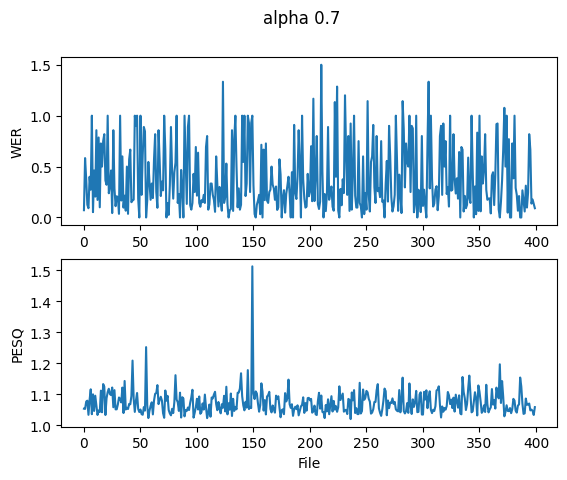

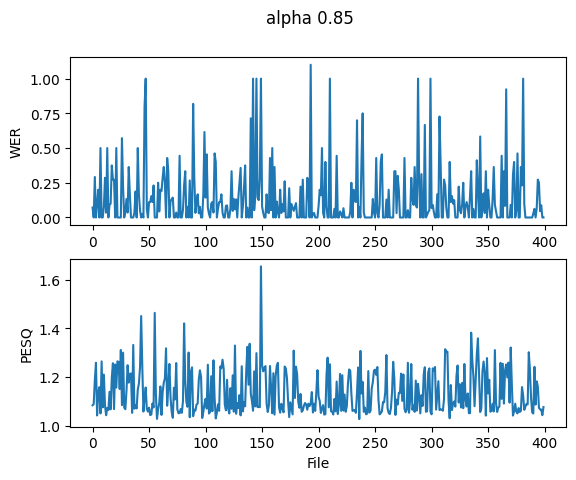

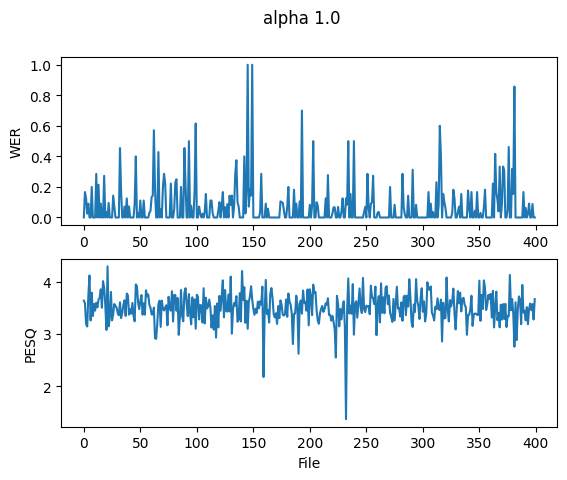

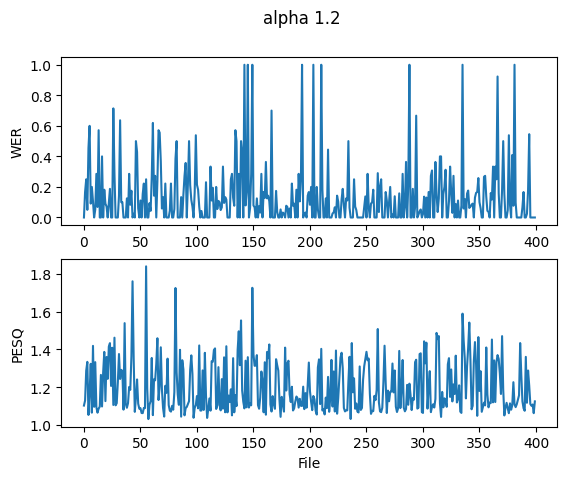

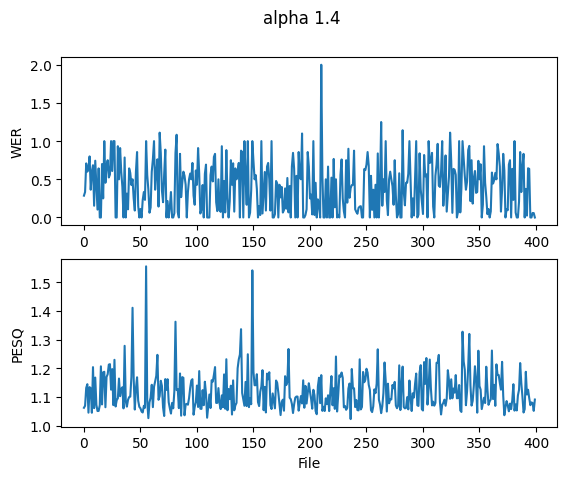

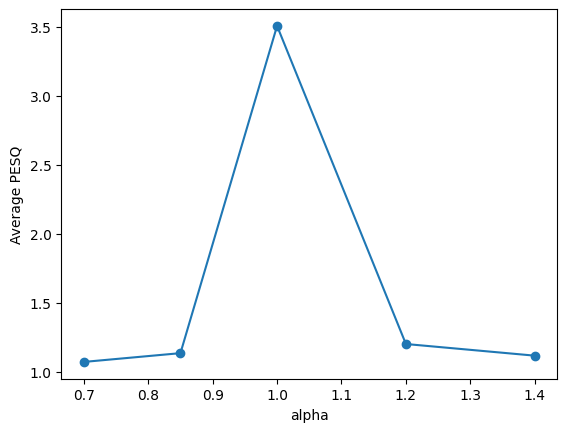

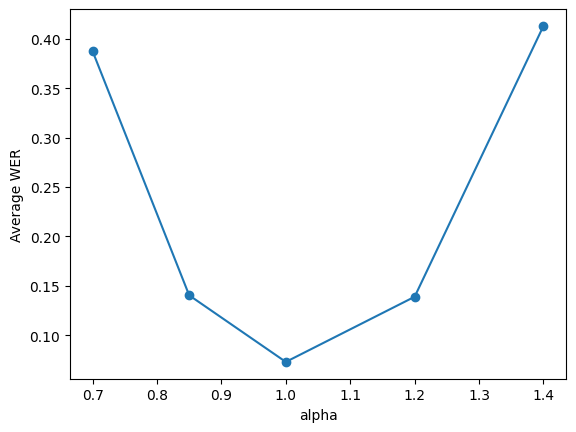

({1.4: {'WER': 0.4132106054550981, 'PESQ': 1.11888525}},
 {1.4: {'WER': [0.2857142857142857,
    0.3333333333333333,
    0.7083333333333334,
    0.6,
    0.6363636363636364,
    0.8,
    0.36363636363636365,
    0.6,
    0.6842105263157895,
    0.15384615384615385,
    0.7435897435897436,
    0.42857142857142855,
    0.10344827586206896,
    0.6428571428571429,
    0.0,
    0.0,
    0.7,
    0.25,
    1.0,
    0.45454545454545453,
    0.6785714285714286,
    0.75,
    0.5238095238095238,
    0.5625,
    1.0,
    0.6086956521739131,
    1.0,
    1.0,
    0.0,
    0.0,
    0.9333333333333333,
    0.5,
    0.9090909090909091,
    0.6,
    0.4,
    0.0,
    0.7857142857142857,
    0.0,
    0.3125,
    0.10714285714285714,
    0.6428571428571429,
    0.5833333333333334,
    0.425,
    0.5,
    0.25,
    0.09090909090909091,
    0.6,
    0.8571428571428571,
    0.15151515151515152,
    0.0,
    0.1111111111111111,
    0.0,
    0.23076923076923078,
    0.3333333333333333,
    0.23076923076923

In [4]:



import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and extract the data
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["WER"] = np.clip(data["WER"], 0,2)

    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["alpha"] = [float(alpha) for alpha in data["alpha"]]


    # Group the data by alpha
    grouped_data = {}
    for alpha, wer, pesq in zip(data["alpha"], data["WER"], data["PESQ"]):
        if alpha not in grouped_data:
            grouped_data[alpha] = {"WER": [], "PESQ": []}
        grouped_data[alpha]["WER"].append(wer)
        grouped_data[alpha]["PESQ"].append(pesq)

    # Calculate the average WER and PESQ for each alpha
    avg_data = {}
    for alpha, alpha_data in grouped_data.items():
        avg_wer = np.mean(alpha_data["WER"])
        avg_pesq = np.mean(alpha_data["PESQ"])
        avg_data[alpha] = {"WER": avg_wer, "PESQ": avg_pesq}

    return avg_data, grouped_data

output_file_paths = [
    Path("OUTPUT07alpha.tsv"),
    Path("OUTPUT085alpha.tsv"),
    Path("OUTPUT1alpha.tsv"),
    Path("OUTPUT12alpha.tsv"),
    Path("OUTPUT14alpha.tsv"),
]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each alpha
    for alpha, alpha_data in grouped_data.items():
        plt.figure()
        plt.suptitle(f"alpha {alpha}")
        plt.subplot(2, 1, 1)
        plt.plot(alpha_data["WER"])
        plt.ylabel("WER")
        plt.subplot(2, 1, 2)
        plt.plot(alpha_data["PESQ"])
        plt.xlabel("File")
        plt.ylabel("PESQ")
        plt.show()

# Plot the average WER data for all alphas
alphas = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each alpha
    # (same as before)

# Plot the average WER data for all alphas
alphas = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]


# Plot the average PESQ data for all alphas
avg_pesqs = [data["PESQ"] for data in all_avg_data.values()]

plt.figure()
plt.plot(alphas, avg_pesqs, 'o-')
plt.xlabel("alpha")
plt.ylabel("Average PESQ")
plt.show()

plt.figure()
plt.plot(alphas, avg_wers, 'o-')
plt.xlabel("alpha")
plt.ylabel("Average WER")
plt.show()

output_file_path = Path("OUTPUT07alpha.tsv")
output_file_path1 = Path("OUTPUT085alpha.tsv")
output_file_path2 = Path("OUTPUT1alpha.tsv")
output_file_path3 = Path("OUTPUT12alpha.tsv")
output_file_path3 = Path("OUTPUT14alpha.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)


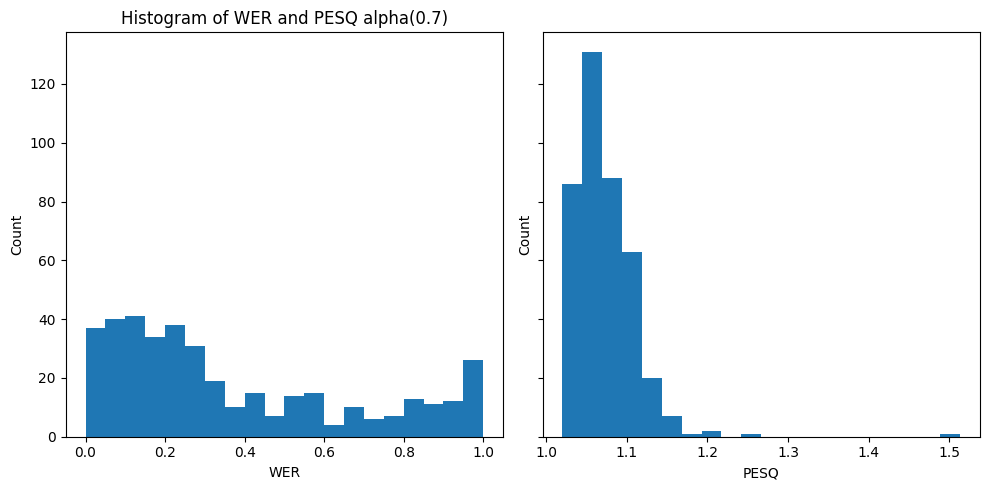

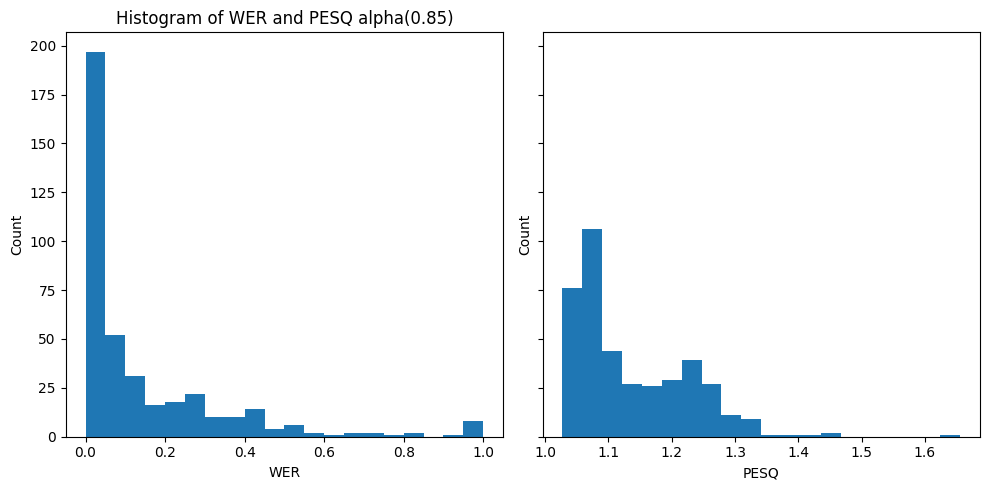

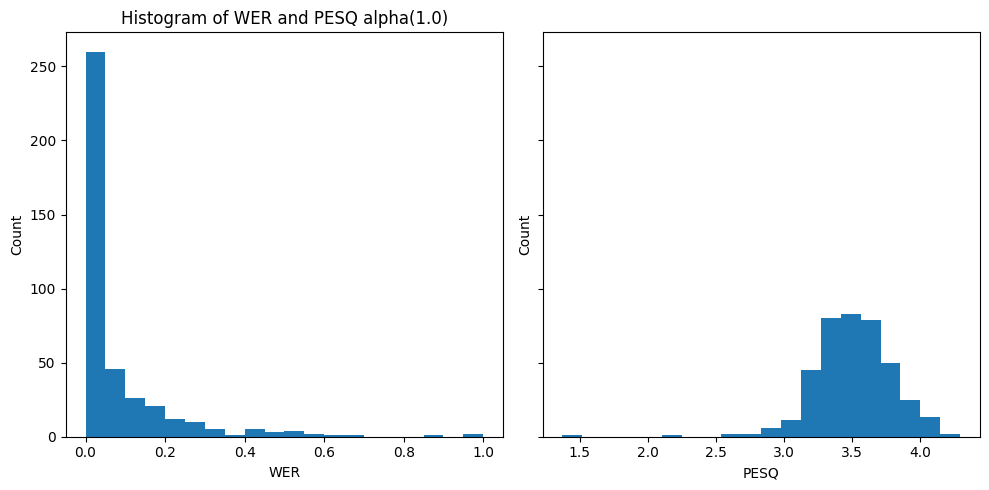

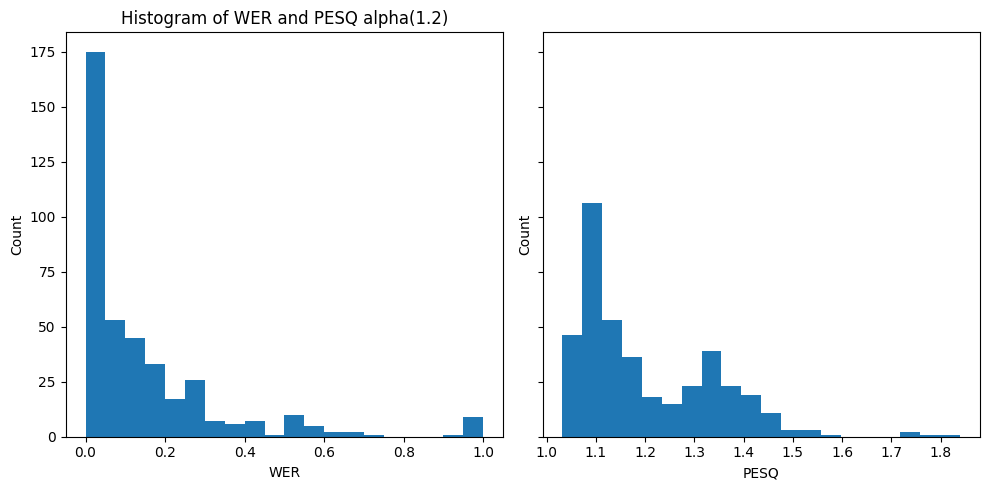

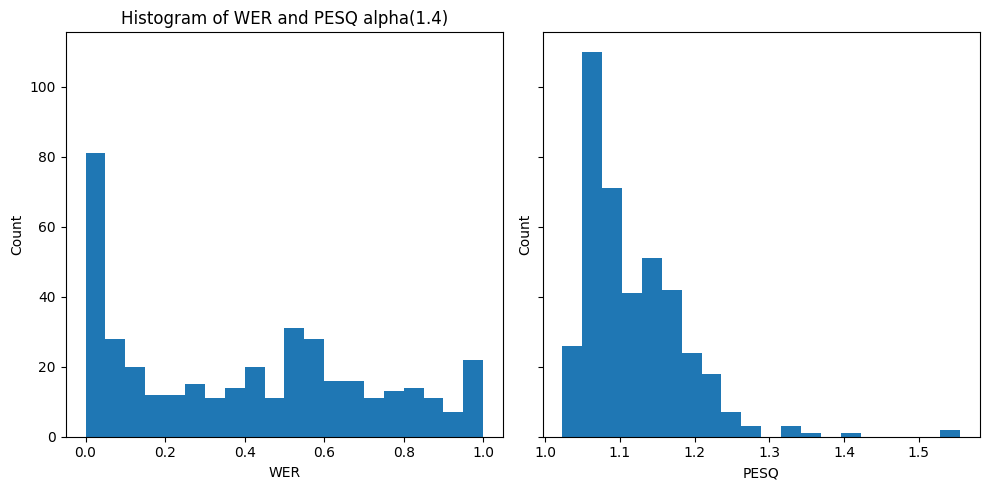

In [6]:
def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by alpha
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["alpha"] = [float(alpha) for alpha in data["alpha"]]


    # Group the data by alpha
    grouped_data = {}
    for alpha, wer, pesq in zip(data["alpha"], data["WER"], data["PESQ"]):
        if alpha not in grouped_data:
            grouped_data[alpha] = {"WER": [], "PESQ": []}
        grouped_data[alpha]["WER"].append(wer)
        grouped_data[alpha]["PESQ"].append(pesq)

    # Create subplots for each alpha level
    num_alphas = len(grouped_data)
    if num_alphas == 1:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(num_alphas, 2, figsize=(10, 10), sharey=True)

    for i, (alpha, alpha_data) in enumerate(grouped_data.items()):
        # Create histograms for WER and PESQ scores
        axs[i][0].hist(alpha_data["WER"], range=(0, 1), bins=20)
        axs[i][1].hist(alpha_data["PESQ"], bins=20)

        # Add labels and titles
        axs[i][0].set_xlabel("WER")
        axs[i][1].set_xlabel("PESQ")
        if num_alphas == 1:
            axs[i][0].set_title(F"Histogram of WER and PESQ alpha({alpha})")
        else:
            axs[i][0].set_title(f"Histogram of WER (alpha {alpha})")
            axs[i][1].set_title(f"Histogram of PESQ (alpha {alpha})")
        axs[i][0].set_ylabel("Count")
        axs[i][1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

output_file_path = Path("OUTPUT07alpha.tsv")
output_file_path1 = Path("OUTPUT085alpha.tsv")
output_file_path2 = Path("OUTPUT1alpha.tsv")
output_file_path3 = Path("OUTPUT12alpha.tsv")
output_file_path4 = Path("OUTPUT14alpha.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)



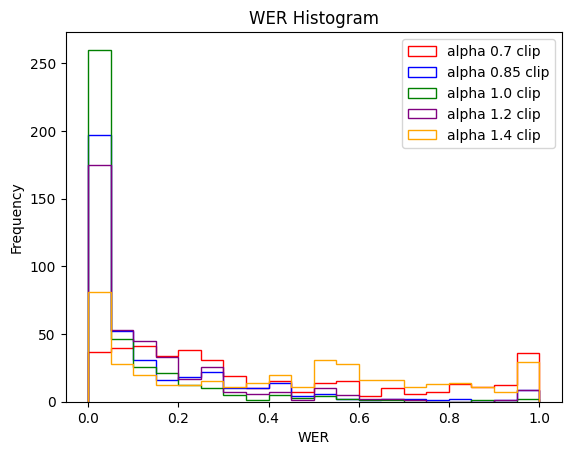

In [7]:

import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by alpha
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["alpha"] = [float(alpha) for alpha in data["alpha"]]


    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], 0, 1)

    return data["alpha"], data["WER"]

# Define colors for each alpha value
alpha_colors = {0.7: 'red', 0.85: 'blue', 1: 'green', 1.2: 'purple', 1.4: 'orange'}

output_file_paths = [
    Path("OUTPUT07alpha.tsv"),
    Path("OUTPUT085alpha.tsv"),
    Path("OUTPUT1alpha.tsv"),
    Path("OUTPUT12alpha.tsv"),
    Path("OUTPUT14alpha.tsv")

]

wer_data = {}
for output_file_path in output_file_paths:
    alpha, wer = plot_wer(output_file_path)
    for alpha_value, wer_value in zip(alpha, wer):
        if alpha_value not in wer_data:
            wer_data[alpha_value] = []
        wer_data[alpha_value].append(wer_value)

plt.figure()
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)

for alpha_value, wer_values in wer_data.items():
    color = alpha_colors[alpha_value]
    plt.hist(wer_values, bins=bins, color=color, histtype='step', label=f'alpha {alpha_value} clip')

#plt.ylim(0, 250)

plt.xlabel("WER")
plt.ylabel("Frequency")
plt.title("WER Histogram")
plt.legend()
plt.show()



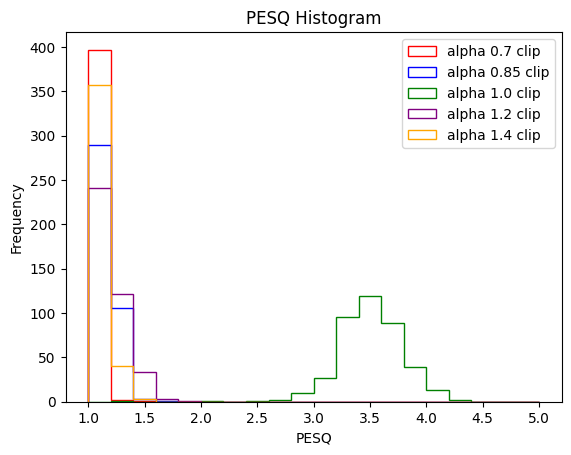

In [9]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by alpha
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["alpha"] = [float(alpha) for alpha in data["alpha"]]


    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["alpha"], data["PESQ"]

# Define colors for each alpha value
alpha_colors = {0.7: 'red', 0.85: 'blue', 1: 'green', 1.2: 'purple', 1.4: 'orange'}

output_file_paths = [
    Path("OUTPUT07alpha.tsv"),
    Path("OUTPUT085alpha.tsv"),
    Path("OUTPUT1alpha.tsv"),
    Path("OUTPUT12alpha.tsv"),
    Path("OUTPUT14alpha.tsv")

]

pesq_data = {}
for output_file_path in output_file_paths:
    alpha, pesq = plot_pesq(output_file_path)
    for alpha_value, pesq_value in zip(alpha, pesq):
        if alpha_value not in pesq_data:
            pesq_data[alpha_value] = []
        pesq_data[alpha_value].append(pesq_value)

plt.figure()
binwidth = 0.2
bins = np.arange(1, 5 + binwidth, binwidth)

for alpha_value, pesq_values in pesq_data.items():
    color = alpha_colors[alpha_value]
    plt.hist(pesq_values, bins=bins, color=color, histtype='step', label=f'alpha {alpha_value} clip')

plt.xlabel("PESQ")
plt.ylabel("Frequency")
plt.title("PESQ Histogram")
plt.legend()
plt.show()


<Figure size 640x480 with 0 Axes>

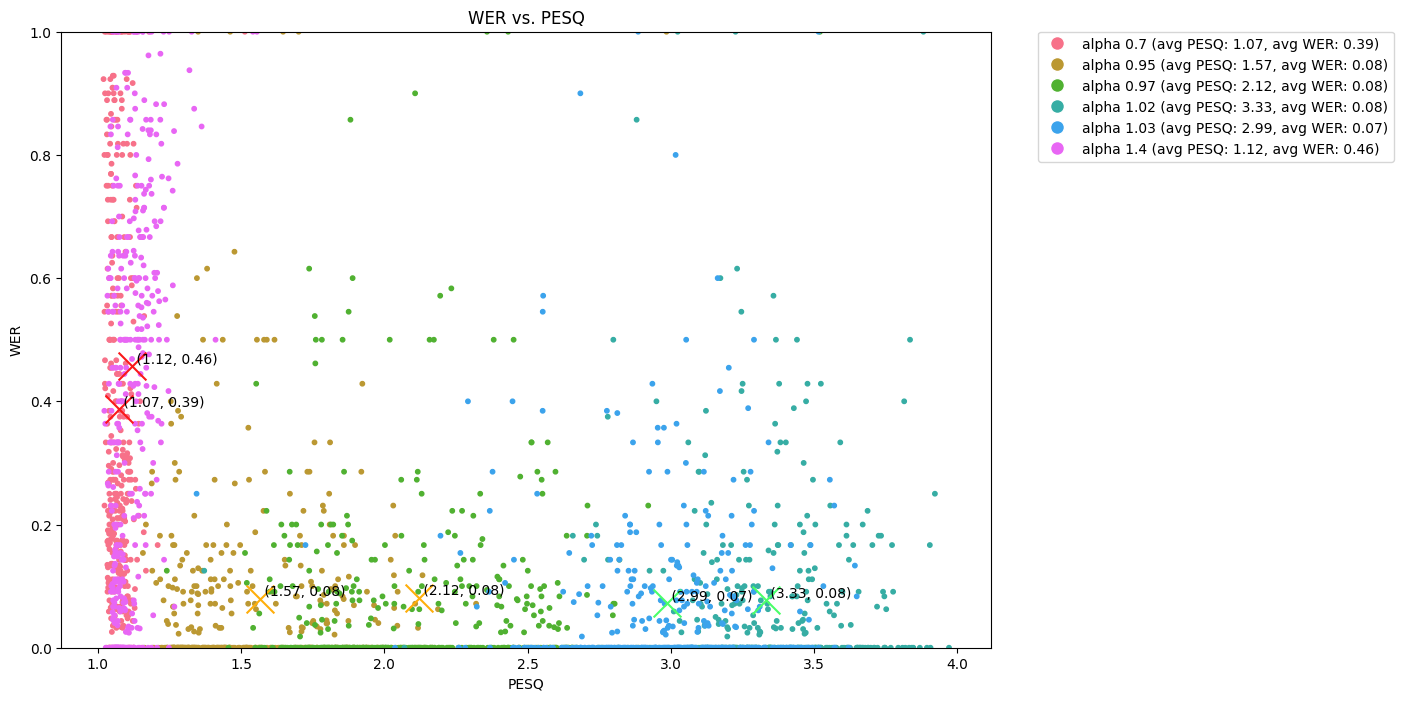

In [6]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

def plot_wer_pesq(output_file_paths):
    grouped_data = {}
    
    for output_file_path in output_file_paths:
        with open(output_file_path, "r") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            header = next(tsv_file)
            for line in tsv_file:
                alpha = float(line[3])
                wer = float(line[1])
                pesq = float(line[2])
                
                if alpha not in grouped_data:
                    grouped_data[alpha] = {'WER': [], 'PESQ': []}
                
                grouped_data[alpha]['WER'].append(wer) 
                grouped_data[alpha]['PESQ'].append(pesq)
    
    alpha_levels = sorted(grouped_data.keys())
    rgb_values = sns.color_palette("husl", len(alpha_levels))
    alpha_colors = dict(zip(alpha_levels, rgb_values))

    X_colors = {
        1.02 : '#4AFF68',
        1.03 : '#4AFF68',
        0.97 : '#FFAE0A',
        0.95 : '#FFAE0A',
        0.7  : '#FA1919',
        1.4  : '#FA1919'
    }

    plt.figure()

    plt.figure(figsize=(12, 8))
    
    avg_values = []

    for alpha, data in grouped_data.items():
        wer = np.array(data['WER'])
        pesq = np.array(data['PESQ'])
        avg_wer = np.mean(wer)
        avg_pesq = np.mean(pesq)
        
        plt.scatter(pesq, wer, c=[alpha_colors[alpha]] * len(wer), label=f'alpha {alpha}', s=10, zorder=1)
        plt.scatter(avg_pesq, avg_wer, c=[X_colors[alpha]], marker='x', s=400, zorder=2)
        plt.text(avg_pesq, avg_wer, f' ({avg_pesq:.2f}, {avg_wer:.2f})', fontsize=10, verticalalignment='bottom', zorder=3)
        avg_values.append((alpha, avg_pesq, avg_wer))

    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.ylim(0,1)
    plt.title("WER vs. PESQ")
    
    legend_elements = [
        plt.Line2D(
            [0], [0], marker='o', color='w', label=f'alpha {x[0]} (avg PESQ: {x[1]:.2f}, avg WER: {x[2]:.2f})', 
            markerfacecolor=alpha_colors[x[0]], markersize=10
        ) for x in avg_values
    ]

    plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()



output_file_paths = [
    Path("OUTPUT07alpha.tsv"),
    Path("OUTPUT095alpha.tsv"),
    Path("OUTPUT097alpha.tsv"),
    Path("OUTPUT102alpha.tsv"),
    Path("OUTPUT103alpha.tsv"),    
    Path("OUTPUT14alpha.tsv"),
]

plot_wer_pesq(output_file_paths)
